In [1]:
#Instal
!pip install yfinance --upgrade --no-cache-dir
# virtualenv -p python3 virtualenvironment
# source virtualenvironment/bin/activate
!pip install ta --upgrade --no-cache-dir
!pip install pandas_ta --upgrade --no-cache-dir
#imports
import time
import sys
from math import floor
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import yfinance as yf
import pandas_datareader as web
import matplotlib.pyplot as plt

from ta.volatility import bollinger_mavg, KeltnerChannel

yf.pdr_override()

In [2]:
#Define functions

#GET YAHOO DATA
def get_data(ticker):    
    ticker_data = web.get_data_yahoo(ticker, START_DATE, END_DATE)
    return ticker_data

def convert_data(ticker_data, ticker):
    
    names = []
    table = []
    
    ticker_data = ticker_data.rename(columns = {ticker:'Close'})
    for i in range(0, LOOP_MAX, SHIFT_DAYS) :
        data = ticker_data[i:CORR_WINDOW + i]
        date = data.index[0]
        ticker_name = ticker + ' ' + date.strftime('%Y/%m/%d')
        names.append(ticker_name)
        data['Ticker'] = ticker_name
        table.append(data)    
        
    return [names, table]

#CREATE DATAFRAMES
def create_dfs(datas_to_df):
    dfs = []
    for data_to_df in datas_to_df :
        name, data = data_to_df
        df = pd.DataFrame()
        df = pd.concat(data)
        df = df.reset_index()
        df = df.pivot(columns='Ticker',values='Close')
        dfs.append(df)
    return dfs

#PIVOT FUNCTIONS
def pivot_df(df_pivot, data, names): 
    for i in range(floor(LOOP_MAX/SHIFT_DAYS)) :
        column_name = names[i]
        values = data[column_name].values
        values = values[~np.isnan(values)]
        values = pd.Series(values)
        df_pivot.insert(len(df_pivot.columns), column_name, values)
        
    return df_pivot

def pivot_all_dfs(dfs, datas):
    dfs_pivoted = []
    names = []
    loop_times = len(dfs) - 1
    
    for j in range(loop_times):
        for i in range(j, loop_times):
            name_to_first = datas[j][0]
            names_to_second = datas[i + 1][0]
            names.append([name_to_first, names_to_second])
            
            df_pivoted = pd.DataFrame()
            df_pivoted = pivot_df(df_pivoted, dfs[j], name_to_first)
            df_pivoted = pivot_df(df_pivoted, dfs[i + 1], names_to_second)
            dfs_pivoted.append(df_pivoted)
        
    return [dfs_pivoted, names]

#CORRELATION FUNCTIONS
def get_corr_df(df_pivot, nameRow, nameColumn):
    #Using corr function to get correlation between actives
    corr_df = df_pivot.corr(method='pearson')
    #reset symbol as index (rather than 0-X)
    corr_df.head().reset_index()
    corr_df = corr_df.rename_axis(None, axis=0)
    corr_df = corr_df.drop(nameRow, axis=1)
    corr_df = corr_df.drop(nameColumn, axis=0)
    
    return corr_df

def get_all_corr_dfs(dfs, names):
    dfs_corr = []
    for i in range(len(dfs)):
        corr_df = get_corr_df(dfs[i], names[i][0], names[i][1])
        dfs_corr.append(corr_df)
    
    return dfs_corr

#INDICATOR FUNCTIONS
def get_indicators(df):
    values = df.values
    means_df = pd.DataFrame()
    deviations_df = pd.DataFrame()
    columns_name = []
    rang = floor(LOOP_MAX/2)
    for i in range(rang):
        means = []
        deviations = []
        row_name = df.index[i] + " - " + df.index[i + CORR_WINDOW].split(' ')[1] 
        for j in range(rang):
            if i == 0:
                column_name = df.columns[j] + " - " + df.columns[j + CORR_WINDOW].split(' ')[1] 
                columns_name.append(column_name)
            ax = []
            for k in range(CORR_WINDOW):
                value = values[i+k][j+k]
                ax.append(value)

            mean = np.average(ax)
            means.append(mean)

            deviation = np.std(ax)
            deviations.append(deviation)
            
        aux_df = pd.DataFrame([means], columns=columns_name, index=[row_name])
        means_df = pd.concat([means_df, aux_df])
        aux_df = pd.DataFrame([deviations], columns=columns_name, index=[row_name])
        deviations_df = pd.concat([deviations_df, aux_df])
        
    return [means_df, deviations_df]

def get_df_plot(dfs_corr):
    means, deviations = get_indicators(dfs_corr)
    
    rang = len(means.index) - SHIFT_DAYS
    values_means = means.values
    values_deviations = deviations.values
    values = []
    columns = [1,2,3,4]
    
    for i in range(rang):
        value = []
        value_mean = values_means[i][i + SHIFT_DAYS]
        value_deviation = values_deviations[i][i + SHIFT_DAYS]
        value.append(value_mean)
        value.append(value_deviation)
        
        value_mean = values_means[i + SHIFT_DAYS][i]
        value_deviation = values_deviations[i + SHIFT_DAYS][i]
        value.append(value_mean)
        value.append(value_deviation)
        
        values.append(value)
    columns = get_columns_name(means)    
    final_df = pd.DataFrame(values, columns=columns)
    return final_df

def get_columns_name(df):
    names = []
    
    for ind in ["Means", "Deviations"]:
        ticker = df.columns[0].split(" ")[0]
        
        index = df.index[0].split(" ")
        start_date = index[1]

        last_index = df.index[len(df.index) - (SHIFT_DAYS + 1)].split(" ") 
        end_date = last_index[1]
        name = ind + " - "
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date + "\n"

        index = df.index[1].split(" ")
        last_index = df.index[-1].split(" ")
        start_date = index[1]
        end_date = last_index[1]
        ticker = index[0]
        
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date
        names.append(name)
        
    for ind in ["Means", "Deviations"]:
        index = df.index[0].split(" ")
        start_date = index[1]
        ticker = index[0]
        last_index = df.index[len(df.index) - (SHIFT_DAYS + 1)].split(" ") 
        end_date = last_index[1]
        
        name = ind + " - "
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date + "\n"

        index = df.index[1].split(" ")
        last_index = df.index[-1].split(" ")
        start_date = index[1]
        end_date = last_index[1]
        ticker = df.columns[0].split(" ")[0]
        
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date
        names.append(name)
        
    return names

def get_price_df(df_p, names):
    df = pd.DataFrame()
    dates = []
    length = len(df_p[names[0]].columns)
    
    column = []    
    ticker = names[0][0].split(" ")[0]
    for i in range(length):
        dates.append(names[0][i].split(" ")[1])
        column.append(df_p[names[0]].values[0][i])
    
    df.insert(len(df.columns), ticker, column)
    
    column = []
    ticker = names[1][0].split(" ")[0]
    for i in range(length):
        column.append(df_p[names[1]].values[0][i])
            
    df.insert(len(df.columns), ticker, column) 
    
    mavg = get_mavg(df)
    df = df.join(mavg)
    df.insert(0, "Date", dates)
    return df

def get_mavg(df, ticker):
    mavg_df = pd.DataFrame()
    
    mavg_aux = bollinger_mavg(df[ticker + "-Close"], window=MAVG_WINDOW, fillna=True)
    mavg_df.insert(0, ticker + "-MA", mavg_aux)
        
    return mavg_df

#Keltner Channel
def get_price_KC(data, ticker):    
    high = list(data["High"][ticker])
    close = list(data["Close"][ticker])
    low = list(data["Low"][ticker])
    
    df_price = pd.DataFrame({ticker + "-High": high, ticker + "-Close": close, ticker + "-Low": low})
    
    KC = KeltnerChannel(high=df_price[ticker + "-High"], 
                        close=df_price[ticker + "-Close"], 
                        low=df_price[ticker + "-Low"], 
                        multiplier=MULTIPLIER, window=20, fillna=True)
    
    return [KC, df_price]

def get_all_price_KC(data):
    lenght = len(data["High"].columns)
    dfs = []
    df_prices = []
    
    dates = list(data.index.strftime('%Y/%m/%d'))
    
    for i in range(lenght):
        ticker1 = tickers[i]
        df_kc1, df_price1 = get_price_KC(data, ticker1)
        high1 = list(df_kc1.keltner_channel_hband())
        low1 = list(df_kc1.keltner_channel_lband())
        mavg1 = get_mavg(df_price1, ticker1)
        df_price1 = df_price1.join(mavg1)
        
        for j in range(i+1, lenght):
            ticker2 = tickers[j]
            df_kc2, df_price2 = get_price_KC(data, ticker2)
            high2 = list(df_kc2.keltner_channel_hband())
            low2 = list(df_kc2.keltner_channel_lband())
            mavg2 = get_mavg(df_price2, ticker2)
            df_price2 = df_price2.join(mavg2)
            
            df_price = df_price1.join(df_price2)
            df_price.insert(0, "date", dates)
            df_prices.append(df_price)
            
            df_aux = pd.DataFrame({ticker1 + "-High": high1, ticker1 + "-Low": low1, 
                                   ticker2 + "-High": high2, ticker2 + "-Low": low2})
            dfs.append(df_aux)
            
    return [dfs, df_prices]

In [3]:
def trade_comprado(corr_df, price_df, kcs_df, predict_stock):
    equity = pd.DataFrame(columns=['Date', 'Profit'])
    
    enter_corr = ENTER_CORR
    
    price_length = len(price_df.index)
    corr_length = len(corr_df.index)
    corr_relation = floor(price_length / corr_length)
    
    date = price_df.columns[0]
    dates = price_df[date]
    
    if(predict_stock == 1):
        stock_a = price_df.columns[2]
        stock_a_mavg = price_df.columns[4]
        
        stock_b_high = price_df.columns[5]
        stock_b = price_df.columns[6]
        stock_b_mavg = price_df.columns[8]

        stock_b_predicting_mean_corr = corr_df.columns[2]

        stock_b_high_kc = kcs_df.columns[2]
    
    else:
        stock_a = price_df.columns[6]
        stock_a_mavg = price_df.columns[8]
        
        stock_b_high = price_df.columns[1]
        stock_b = price_df.columns[2]
        stock_b_mavg = price_df.columns[4]

        stock_b_predicting_mean_corr = corr_df.columns[0]

        stock_b_high_kc = kcs_df.columns[0]
        
    file = open(path_comprado + stock_b + ".txt", "a+")
            
    nmb_stock = 0
    nmb_orders = 0
    paid_stock = 0
    money = 1000
    sell_cause = ""
    bought = False

    title = "Using {0} to predict {1}\n".format(stock_a, stock_b)
    file.write(title)

    for i in range(price_length):
        stock_price = price_df[stock_b][i]
        high_stock_price = price_df[stock_b_high][i]

        aux = floor(i / corr_relation)
        if aux >= corr_length:
            aux = corr_length - 1

        if bought:
            if high_stock_price > kcs_df[stock_b_high_kc][i]:
                sell_cause = "Better than KC"
                bought = False
            if price_df[stock_a][i] < price_df[stock_a_mavg][i]:
                sell_cause = "{0} is low than mavg".format(stock_a)
                bought = False

            if not bought:
                if(nmb_stock > 0):
                    profit = ((stock_price * nmb_stock) - (paid_stock * nmb_stock))
                    EC_aux = pd.DataFrame([{"Date": dates[i], "Profit": profit}])
                    equity = equity.append(EC_aux)
                money += stock_price * nmb_stock
                nmb_stock = 0
                file.write("selling in {0} - money: {1} - cause:{2}\n".format(dates[i], money, sell_cause))#stonk prices
                nmb_orders += 1
        else:
            if price_df[stock_a][i] > price_df[stock_a_mavg][i]:
                if stock_price < price_df[stock_b_mavg][i]:
                    if corr_df[stock_b_predicting_mean_corr][aux] > enter_corr:
                        bought = True
                        nmb_stock = floor(money/stock_price)
                        money = money%stock_price
                        paid_stock = stock_price
                        file.write("buying in {0} - money: {1}, stocks: {2}\n".format(dates[i], money, nmb_stock))
                        nmb_orders += 1
    file.write("Money in final of tests {0} and Number of orders {1}\n\n".format(money, nmb_orders))
    
    file.close()
 
    return [equity, nmb_orders]

def trade_vendido(corr_df, price_df, kcs_df, predict_stock):
    equity = pd.DataFrame(columns=['Date', 'Profit'])
    
    enter_corr = ENTER_CORR
    
    price_length = len(price_df.index)
    corr_length = len(corr_df.index)
    corr_relation = floor(price_length / corr_length)
    
    date = price_df.columns[0]
    dates = price_df[date]
    
    if(predict_stock == 1):
        
        stock_a = price_df.columns[2]
        stock_a_mavg = price_df.columns[4]
        
        stock_b = price_df.columns[6]
        stock_b_low = price_df.columns[7]
        stock_b_mavg = price_df.columns[8]

        stock_b_predicting_mean_corr = corr_df.columns[2]

        stock_b_low_kc = kcs_df.columns[3]
    
    else:
        stock_a = price_df.columns[6]
        stock_a_mavg = price_df.columns[8]
        
        stock_b = price_df.columns[2]
        stock_b_low = price_df.columns[3]
        stock_b_mavg = price_df.columns[4]
        
        stock_b_predicting_mean_corr = corr_df.columns[0]
        
        stock_b_low_kc = kcs_df.columns[1]
        
    file = open(path_vendido + stock_b + ".txt", "a+")
    
    nmb_stock = 0
    nmb_orders = 0
    sold_stock = 0
    money = 1000
    purchase_cause = ""
    sold = True

    title = "Using {0} to predict {1}\n".format(stock_a, stock_b)
    file.write(title)

    for i in range(price_length):
        stock_price = price_df[stock_b][i]
        low_stock_price = price_df[stock_b_low][i]

        aux = floor(i / corr_relation)
        if aux >= corr_length:
            aux = corr_length - 1

        if sold:
            if low_stock_price < kcs_df[stock_b_low_kc][i]:
                purchase_cause = "Lower than KC"
                sold = False
            if price_df[stock_a][i] > price_df[stock_a_mavg][i]:
                purchase_cause = "{0} is better than mavg".format(stock_a)
                sold = False

            if not sold:
                nmb_stock = floor(money/stock_price)
                money = money%stock_price
                if(sold_stock != 0):
                    profit = ((sold_stock * nmb_stock) - (stock_price * nmb_stock))
                    EC_aux = pd.DataFrame([{"Date": dates[i], "Profit": profit}])
                    equity = equity.append(EC_aux)
                file.write("Buying in {0} - money: {1},  stocks: {2} - cause:{3}\n".format(dates[i], money, nmb_stock, purchase_cause))
                nmb_orders += 1

        else:
            if price_df[stock_a][i] < price_df[stock_a_mavg][i]:
                if stock_price > price_df[stock_b_mavg][i]:
                    if corr_df[stock_b_predicting_mean_corr][aux] > enter_corr:
                        sold = True
                        money += stock_price * nmb_stock
                        nmb_stock = 0
                        sold_stock = stock_price
                        file.write("Selling in {0} - money: {1}\n".format(dates[i], money))
                        nmb_orders += 1

    file.write("Money in final of tests {0} and Number of orders {1}\n\n".format(money, nmb_orders))
        
    file.close()
    return [equity, nmb_orders]

In [4]:
#Constants
#Fazer mais simulações
SHIFT_DAYS = 1
CORR_WINDOW = 9 # 5,7,9
MAVG_WINDOW = 42 # 36,38,40,42
MULTIPLIER = 1 # 1,2,3
ENTER_CORR = 0.7

START_DATE = datetime(2019, 1, 1)
END_DATE = datetime(2021, 1, 1)

In [5]:
#Load data
tickers = ['ENBR3.SA','VALE3.SA','ITUB3.SA','BBAS3.SA','BBSE3.SA', 'PSSA3.SA']
len_tickers = len(tickers)
range_len_tickers = range(len_tickers)

loaded_datas = get_data(tickers)

LOOP_MAX = len(loaded_datas) - CORR_WINDOW - SHIFT_DAYS

path_comprado = "trade_comprado"
path_vendido = "trade_vendido"

In [9]:
def new_parameters(profit, key, nmb_orders):
    new_parameters = parameters[key]
    
    new_parameters['PROFIT'] = profit
    new_parameters['CORR_WINDOW'] = CORR_WINDOW
    new_parameters['MAVG_WINDOW'] = MAVG_WINDOW
    new_parameters['MULTIPLIER'] = MULTIPLIER
    new_parameters['ENTER_CORR'] = ENTER_CORR 
    new_parameters['ORDERS'] = nmb_orders
    
    parameters[key] = new_parameters
    return

parameters = {}
for i in range_len_tickers:
    for j in range(i+1, len_tickers, 1):
        key = 'Using {0} to predict {1}'.format(tickers[j].split('.')[0],tickers[i].split('.')[0])
        parameters[key] = {'PROFIT': -sys.maxsize, 'CORR_WINDOW': 0, 'MAVG_WINDOW': 0, 'MULTIPLIER': 0, 'ENTER_CORR': 0, 'ORDERS': 0}
        key = 'Using {0} to predict {1}'.format(tickers[i].split('.')[0],tickers[j].split('.')[0])
        parameters[key] = {'PROFIT': -sys.maxsize, 'CORR_WINDOW': 0, 'MAVG_WINDOW': 0, 'MULTIPLIER': 0, 'ENTER_CORR': 0, 'ORDERS': 0}

for corr_window in [5,7,9]:
    CORR_WINDOW = corr_window
    LOOP_MAX = len(loaded_datas) - CORR_WINDOW - SHIFT_DAYS

    all_data = []
    for ticker in tickers:
        data = convert_data(pd.DataFrame(loaded_datas["Close"][ticker]), ticker)
        all_data.append(data)
    
    dfs = create_dfs(all_data)
        
    dfs_pivoted, names = pivot_all_dfs(dfs, all_data)

    dfs_corr = get_all_corr_dfs(dfs_pivoted, names)
    
    len_dfs_corr = len(dfs_corr)
    range_len_dfs_corr = range(len_dfs_corr)
    
    indicators_dfs = []
    for i in range_len_dfs_corr:
        aux_ind = get_df_plot(dfs_corr[i])
        indicators_dfs.append(aux_ind)
        
    for mavg_window in [36,38,40,42]:
        MAVG_WINDOW = mavg_window
                    
        for multiplier in [1,2,3]:
            MULTIPLIER = multiplier
            
            dfs_kc, prices_dfs = get_all_price_KC(loaded_datas)
            
            for enter_corr in [0.64,0.66,0.68,0.7,0.72]:
                ENTER_CORR = enter_corr
                
                for i in range_len_dfs_corr:
                    for number in [1,0]:
                        
                        equity_curve = pd.DataFrame(columns=['Date', 'Profit'])
                        
                        if number == 0:
                            key = list(parameters.keys())[(i * 2) + 1]
                        else:
                            key = list(parameters.keys())[(i * 2)]
                            
                        equity_aux, nmbs = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i], number)
                        nmb_orders = nmbs
                        equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
                        equity_aux, nmbs = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i], number)
                        nmb_orders += nmbs
                        equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)

                        equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
                        list_equity_curve = list(equity_curve['Profit'].values)
                        final_profit = list_equity_curve[-1] if len(list_equity_curve) > 0 else 0

                        if(final_profit > parameters[key]['PROFIT']):
                            new_parameters(final_profit, key, nmb_orders)

C:\Users\turen\AppData\Local\Temp/ipykernel_7308/2651481647.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker_name
C:\Users\turen\AppData\Local\Temp/ipykernel_7308/1639896531.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_pivoted, names = pivot_all_dfs(dfs, all_data)


In [7]:
pd.DataFrame(parameters).values[0].sum()
# pd.DataFrame(parameters).to_excel("out.xlsx")

3641.6146087646484

In [7]:
pd.DataFrame(parameters).values[0].sum()

3605.689872741699

In [8]:
all_data = []

for ticker in tickers:
    data = convert_data(pd.DataFrame(loaded_datas["Close"][ticker]), ticker)
    all_data.append(data)

dfs = create_dfs(all_data)
    
#Pivoting table to aggregate active price in a line of each date
dfs_pivoted, names = pivot_all_dfs(dfs, all_data)

dfs_corr = get_all_corr_dfs(dfs_pivoted, names)

len_dfs_corr = len(dfs_corr)
range_len_dfs_corr = range(len_dfs_corr)

C:\Users\turen\AppData\Local\Temp/ipykernel_224/2651481647.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker_name
C:\Users\turen\AppData\Local\Temp/ipykernel_224/2573673059.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_pivoted, names = pivot_all_dfs(dfs, all_data)


In [9]:
# fig, corr_ax = plt.subplots()
indicators_dfs = []
prices_dfs = []

for i in range_len_dfs_corr:
    aux_ind = get_df_plot(dfs_corr[i])
    indicators_dfs.append(aux_ind)
    
#     price_df = get_price_df(dfs_pivoted[i], names[i])
#     prices_dfs.append(price_df)

# for i in range(2): 
#     mean = final_df.columns[i * 2]
#     deviation = final_df.columns[(i * 2) + 1]
#     plt.fill_between(final_df.index, final_df[mean] - final_df[deviation], final_df[mean] + final_df[deviation], alpha=0.2)
#     final_df.plot(y=mean,figsize=(10,10), xlim=[0, len(final_df[mean]) - 1], ylim=[-1,1], grid=True, ax=corr_ax)

In [10]:
dfs_kc, prices_dfs = get_all_price_KC(loaded_datas) #PEGAR DATAS

prices_dfs[0]
# fig, price_ax = plt.subplots()

# price_df.plot(figsize=(10,10), xlim=[0, len(price_df) - 1], grid=True, ax=price_ax)

,date,ENBR3.SA-High,ENBR3.SA-Close,ENBR3.SA-Low,ENBR3.SA-MA,VALE3.SA-High,VALE3.SA-Close,VALE3.SA-Low,VALE3.SA-MA
0,2019/01/02,14.400000,14.180000,13.980000,14.180000,51.369999,51.090000,49.790001,51.090000
1,2019/01/03,14.800000,14.770000,14.180000,14.475000,50.939999,49.000000,48.400002,50.045000
2,2019/01/04,15.020000,14.880000,14.690000,14.610000,52.450001,52.189999,49.820000,50.760000
3,2019/01/07,14.920000,14.450000,14.230000,14.570000,53.650002,51.910000,51.720001,51.047500
4,2019/01/08,14.760000,14.500000,14.480000,14.556000,52.799999,52.410000,51.619999,51.320000
...,...,...,...,...,...,...,...,...,...
491,2020/12/22,19.690001,19.510000,19.450001,18.766905,86.989998,86.940002,85.430000,72.978809
492,2020/12/23,19.730000,19.540001,19.469999,18.797857,87.529999,87.360001,86.400002,73.556429
493,2020/12/28,19.889999,19.830000,19.549999,18.839524,88.580002,87.309998,87.080002,74.124524
494,2020/12/29,20.059999,19.830000,19.740000,18.882381,88.199997,87.070000,86.510002,74.709524


In [11]:
#Testes
dfs_kc[0]
# equity_curve = pd.DataFrame(data=[{"Date": "2021/07/11", "Profit": -10},{"Date": "2022/05/12", "Profit": 50}, {"Date": "2020/06/11", "Profit": 20}],columns=['Date', 'Profit'])
# EC_aux = pd.DataFrame([{"Date": "2022/06/11", "Profit": -15}])
# equity_curve = pd.concat([equity_curve, EC_aux])
# equity_curve.sort_values(by='Date')
# equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
# equity_curve

,ENBR3.SA-High,ENBR3.SA-Low,VALE3.SA-High,VALE3.SA-Low
0,14.606667,13.766666,52.329998,49.170002
1,14.905000,13.865000,52.158331,48.038336
2,15.001111,14.087778,52.811110,48.311112
3,15.056667,14.026666,53.197499,48.857501
4,15.017334,14.081333,53.249333,49.305334
...,...,...,...,...
491,19.693500,18.844500,84.353334,80.423333
492,19.747166,18.894167,84.900000,81.086000
493,19.793000,18.956000,85.488334,81.644333
494,19.847666,19.007667,85.935500,82.123500


<AxesSubplot:xlabel='Date'>

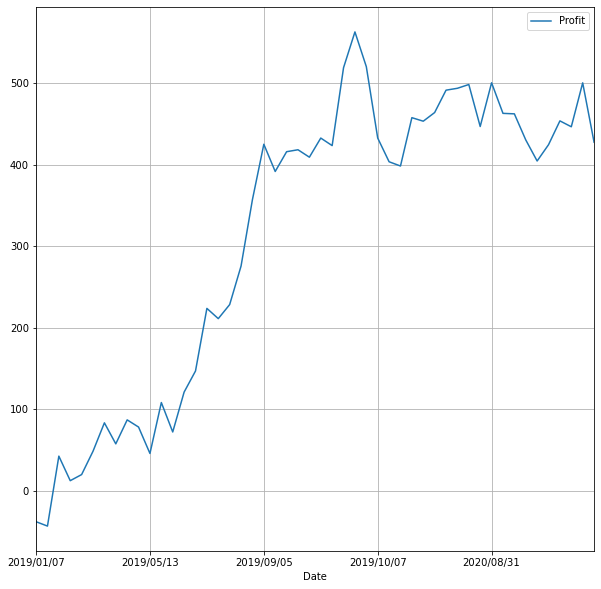

In [13]:
import os

path_comprado = "trade_comprado.txt"
path_vendido = "trade_vendido.txt"

if os.path.exists(path_comprado):
    os.remove(path_comprado)
if os.path.exists(path_vendido):
    os.remove(path_vendido)

equity_curve = pd.DataFrame(columns=['Date', 'Profit'])

for i in range_len_dfs_corr:
    equity_aux, nmbs = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 1)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux, nmbs = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 0)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux, nmbs = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 1)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux, nmbs = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 0)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    
equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
equity_curve

fig, equity_ax = plt.subplots()

equity_curve.plot(figsize=(10,10), xlim=[0, len(equity_curve) - 1], grid=True, ax=equity_ax)

In [63]:
prices_dfs[0]

,date,ENBR3.SA-High,ENBR3.SA-Close,ENBR3.SA-Low,ENBR3.SA-MA,VALE3.SA-High,VALE3.SA-Close,VALE3.SA-Low,VALE3.SA-MA
0,2019/01/02,14.400000,14.180000,13.980000,14.180000,51.369999,51.090000,49.790001,51.090000
1,2019/01/03,14.800000,14.770000,14.180000,14.475000,50.939999,49.000000,48.400002,50.045000
2,2019/01/04,15.020000,14.880000,14.690000,14.610000,52.450001,52.189999,49.820000,50.760000
3,2019/01/07,14.920000,14.450000,14.230000,14.570000,53.650002,51.910000,51.720001,51.047500
4,2019/01/08,14.760000,14.500000,14.480000,14.556000,52.799999,52.410000,51.619999,51.320000
...,...,...,...,...,...,...,...,...,...
491,2020/12/22,19.690001,19.510000,19.450001,18.766905,86.989998,86.940002,85.430000,72.978809
492,2020/12/23,19.730000,19.540001,19.469999,18.797857,87.529999,87.360001,86.400002,73.556429
493,2020/12/28,19.889999,19.830000,19.549999,18.839524,88.580002,87.309998,87.080002,74.124524
494,2020/12/29,20.059999,19.830000,19.740000,18.882381,88.199997,87.070000,86.510002,74.709524
